In [3]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os


#Librería de estadística
import scipy as sp

#librería para manejo de fechas
from datetime import datetime,timedelta


# from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use("seaborn")
mp.rcParams['font.size'] = 20

In [4]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

In [5]:
rutas = np.sort(glob.glob("../Dataset/CMEMS_ECMFW/*.nc"))

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

In [6]:
sla[sla<=-1000]=np.nan

In [7]:
serie=np.nanmean(sla,axis=1)
serie_temp=np.nanmean(serie,axis=1)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [8]:
da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)

In [9]:
serie_sla=pd.Series(serie_temp,date)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


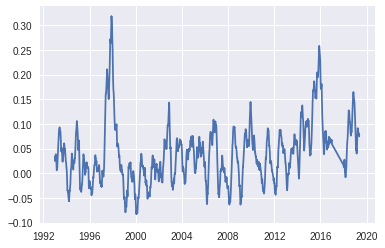

In [10]:
plt.plot(serie_sla)

In [11]:
serie_rolling=serie_sla.rolling(366).mean()
serie_rolling=serie_rolling[365:]

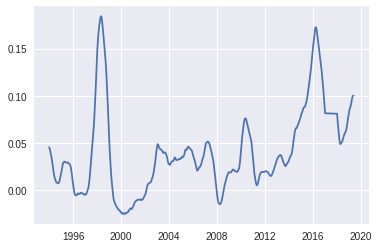

In [12]:
plt.plot(serie_rolling)

In [13]:
freq_sla=np.fft.fftfreq(len(serie_rolling))
fft_sla=np.fft.fft(serie_rolling.values)
potencia=np.abs((1/len(serie_rolling))*fft_sla)**2 #Notar que tiene el factor de escalamiento 1/n
periodo=1/freq_sla
freq_pos=np.where(freq_sla>=0)[0]

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


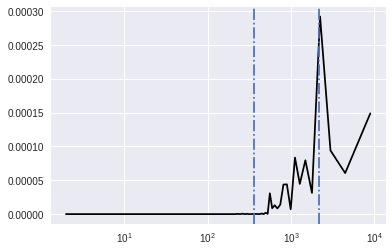

In [14]:
plt.plot(periodo[freq_pos],potencia[freq_pos],'k')
plt.xscale('log')
plt.axvline(365,ls='-.')
plt.axvline(365*6,ls='-.')

Estadísticamente significativo no necesariamentes es físicamente significativo

- para algo físicamente significativo se puede notar el porcentaje de varianza
- para algo estadísticamente significativo se debe mirar la longitud los datos y qué tan casual es que ese espectro se haya obtenido con datos aleatorios (random) y con parámetros estadísticos similares.


* Ruido blanco: ruido no correlacionado (radio sin frecuencia emitida)
* Ruido rojo: ruido correlacionado

In [15]:
serie_copy=np.copy(serie_rolling.values)

In [16]:
n=1000
matriz=np.zeros((n,len(serie_copy)))*np.nan
for i in range(n):
    np.random.shuffle(serie_copy)
    fft_sla2=np.fft.fft(serie_copy)
    potencia2=np.abs((1/len(serie_copy))*fft_sla2)**2 #Notar que tiene el factor de escalamiento 1/n
    matriz[i,:]=potencia2

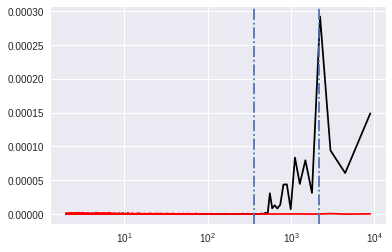

In [17]:
plt.plot(periodo[freq_pos],potencia[freq_pos],'k')
plt.plot(periodo[freq_pos],matriz[800,:][freq_pos],'r')
plt.xscale('log')
plt.axvline(365,ls='-.')
plt.axvline(365*6,ls='-.')

In [18]:
perc_95=np.array([np.percentile(matriz[:,i],99) for i in range (0,len(freq_sla))])

In [19]:
perc_95

array([1.45923446e-03, 9.81233389e-07, 1.20332521e-06, ...,
       9.72796319e-07, 1.20332521e-06, 9.81233389e-07])

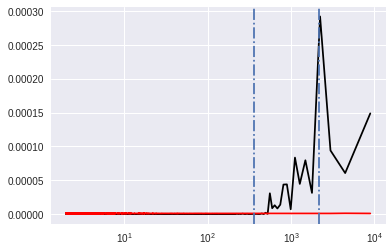

In [20]:
plt.plot(periodo[freq_pos],potencia[freq_pos],'k')
plt.plot(periodo[freq_pos],perc_95[freq_pos],'r')
plt.xscale('log')

plt.axvline(365,ls='-.')
plt.axvline(365*6,ls='-.')

## EOF's

In [22]:
sla.shape

(9289, 45, 185)

In [25]:
sla_r = np.reshape(sla,[sla.shape[0],sla.shape[1]*sla.shape[2]])

In [43]:
%%time
U_sla,S_sla,Vh_sla = np.linalg.svd(sla_r, full_matrices=True)

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [ ]:
print(U_air.shape, S_air.shape,Vh_air.shape)